<a href="https://colab.research.google.com/github/AllanKamimura/Pai_ta_ON_python/blob/main/school/SME0305_PDE_Elliptical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importa as bibliotecas
import time
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import clear_output

sns.set_theme("poster")

# Gauss-Seidel simples
não faz nenhuma verificação de convergencia

In [2]:
def gauss_seidel(A, b, w = 1, maxerro = 10 ** -3):
    D = A.diagonal()
    A = A / np.vstack(A.diagonal())
    b = b.squeeze() / A.diagonal()

    x = np.zeros(b.shape)

    upper = A - np.tril(A)
    lower = A - np.triu(A)

    for itera in range(10000):
        x_old = x.copy()
        for i in range(A.shape[0]):
            x[i] = (1 - w) * x[i] + w * (b[i] - lower[i] @ x - upper[i] @ x_old)
        
        erro = np.max(abs(x - x_old)) / max(np.max(abs(x_old)), 10 ** -7)

        if itera % 12 == 0:
            print("Erro: ", erro)
            clear_output(wait=True)

        if erro < maxerro:
            print(itera)
            break

    return x

In [3]:
def draw(T, x_max, y_max, label, T_min, T_max, cmap = "rainbow"):
    i_max, j_max = T.shape
    
    sns.heatmap(T.T, 
                xticklabels = [int(np.linspace(0,x_max ,11)[int(x/int(i_max / 10))]) if x % int(i_max / 10) == 0 else "" for x in range(i_max + 1)],
                yticklabels = [int(np.linspace(0,y_max ,11)[int(y/int(j_max / 10))]) if y % int(j_max / 10) == 0 else "" for y in range(j_max + 1)],
                cmap = cmap, 
                cbar_kws = {"label": label, "extend": "both", "ticks": np.linspace(T_min,T_max ,7)},
                vmin = 1.1 * T_min, vmax = 1.1 * T_max
                ).invert_yaxis()
    
    _ = plt.yticks(rotation=0)
    return 

# Equação de Laplace para temperatura

$
\frac{\partial^{2}}{\partial x^{2}} T{\left(x,y \right)} + \frac{\partial^{2}}{\partial y^{2}} T{\left(x,y \right)} = 0
$

onde

$
\begin{cases}
\frac{\partial^{2}}{\partial x^{2}} T{\left(x,y \right)} = T{\left(x - 1,y \right)} - 2 T{\left(x,y \right)} + T{\left(x + 1,y \right)}
\\
\frac{\partial^{2}}{\partial y^{2}} T{\left(x,y \right)} = T{\left(x,y - 1 \right)} - 2 T{\left(x,y \right)} + T{\left(x,y + 1 \right)}
\end{cases}
$

Logo

$
4 T{\left(x,y \right)} = T{\left(x,y - 1 \right)} + T{\left(x,y + 1 \right)} + T{\left(x - 1,y \right)} + T{\left(x + 1,y \right)}
$

A temperatura de um ponto é igual a media aritmetica dos 4 pontos adjacentes

In [4]:
# escreve a equação em LATEX
import sympy

x = sympy.symbols("x")
y = sympy.symbols("y")
T = sympy.Function("T")

eq = sympy.Equality(sympy.diff(T(x,y),x,x) + sympy.diff(T(x,y),y,y),0)

print(sympy.latex(eq))
print("")
eq

\frac{\partial^{2}}{\partial x^{2}} T{\left(x,y \right)} + \frac{\partial^{2}}{\partial y^{2}} T{\left(x,y \right)} = 0



Eq(Derivative(T(x, y), (x, 2)) + Derivative(T(x, y), (y, 2)), 0)

In [5]:
# metodo SOR 
# se quiser fazer o plot a cada iteração (demora muito mais)
plotar = False
folder = "fig" # nome da pasta onde as figuras são salvas
!mkdir ./$folder

def laplace_sor(T, x_max, y_max, w = 1, erromax = 10 ** -3):
    # inicializa as coisas
    i_max, j_max = T.shape
    x_step = x_max / (i_max - 1)
    y_step = y_max / (j_max - 1)
    beta = (x_step / y_step) ** 2 
    erro = 100 

    T_max = np.max(T)
    T_min = np.min(T)

    # faz a iteração
    for itera in range(100000):
        
        # armazena uma copia da matriz anterior
        T_old = T.copy()

        # aplica Gauss-Seidel com Sucessive Over Relaxation
        for i in range(1,i_max-1):
            for j in range(1,j_max-1):
                T[i,j] = T_old[i,j] * (1 - w) + w * (T[i + 1, j] + T[i - 1, j] + beta * (T[i, j + 1] + T[i, j - 1])) / (2 * beta + 2) 

        if plotar:
            # plota a figura a cada iteração
            plt.figure(figsize = (10,8)) #inicia a figura com um tamanho especifico

            label = "Temperatura (°C)"
            draw(T, x_max, y_max, label, T_min, T_max)

            plt.title("Iter: {}    Variação: {:.5f}".format(str(itera).zfill(3), erro))
            plt.tight_layout()
            plt.savefig("./{}/{}".format(folder, str(itera).zfill(3)))
            plt.close()

        # calcula o erro, se for menor do que o threshold, para a iteração
        erro = np.max(np.abs(T - T_old)) / np.max(np.abs(T_old)) 
        if erro < erromax:
            break

    print(itera)
    return T

91
Execution time: 0.76874


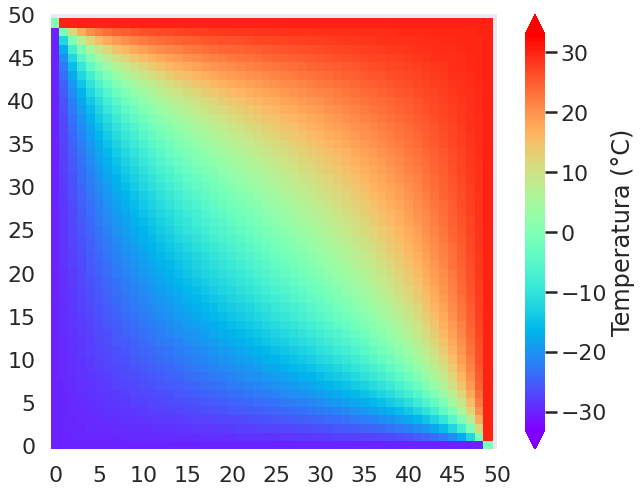

In [6]:
# numero maximo de pontos na malha
i_max, j_max = 50, 50
T = np.zeros((i_max,j_max)) 

# aplica as condições de contorno
# temperatura das paredes é fixa
T[0,:]       =-30;
T[i_max-1,:] = 30;
T[:,j_max-1] = 30;
T[:,0]       =-30;
# temperatura nas 4 quinas é a media das paredes
T[i_max-1,j_max-1] = 0.5*(T[i_max-2,j_max-1] + T[i_max-1,j_max-2]);
T[0,0]             = 0.5*(T[1,0] + T[0,1]);
T[0,j_max-1]       = 0.5*(T[1,j_max-1] + T[0,j_max-2]);
T[i_max-1,0]       = 0.5*(T[i_max-2,0] + T[i_max-1,1]);

# inicia o cronometro
start_time = time.time()

# resolve as equações de laplace pras condições de contono
x_max, y_max = 50, 50
T = laplace_sor(T, x_max, y_max, w = 1.8)

# faz o plot
plt.figure(figsize = (10,8)) #inicia a figura com um tamanho especifico

T_max = np.max(T)
T_min = np.min(T)
label = "Temperatura (°C)"
draw(T, x_max, y_max, label, T_min, T_max)
_ = plt.yticks(rotation=0) 

# para o cronometro
print("Execution time: {:.5f}".format(time.time() - start_time))

In [7]:
X, Y = np.meshgrid([i for i in range(i_max)], [j for j in range(j_max)])
fig = go.Figure(data=[go.Surface(x = X, y = Y, z = T.T, colorscale = "rainbow")])
fig.update_layout(width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [8]:
# metodo de matriz

def laplace_matriz(T, x_max, y_max, w = 1, erromax = 10 ** -3):
    i_max, j_max = T.shape
    x_step = x_max / (i_max - 1)
    y_step = y_max / (j_max - 1)
    beta = (x_step / y_step) ** 2;
    
    A = np.zeros((i_max*j_max, i_max*j_max));
    b = np.zeros((i_max*j_max, 1));
    
    for i in range(i_max):
        for j in range(j_max):
            ind = i + j*i_max;

            # pontos a serem resolvidos
            if ( i > 0 and i < i_max -1 and j > 0 and j < j_max - 1):

                # pontos em volta do ponto desejado
                indip1        = (i+1) + (j+0)*i_max;
                indim1        = (i-1) + (j+0)*i_max;
                indjp1        = (i+0) + (j+1)*i_max;
                indjm1        = (i+0) + (j-1)*i_max;
                
                # coeficientes dos pontos ao redor
                A[ind,indip1] = 1;
                A[ind,indim1] = 1;
                A[ind,indjp1] = beta;
                A[ind,indjm1] = beta;
            
                # coeficiente do ponto a ser resolvido
                A[ind,ind]    = -2 - 2 * beta;

            # pontos das condições de contorno
            else:
                A[ind,ind] = 1;
                b[ind,0]   = T[i,j];

    # resolve o sistema
    T = gauss_seidel(A, b, w, erromax)

    # reorganiza o vetor solução de volta para a matrix
    # pra entender oq ta acontecendo aqui, faz uns testes com matrizes pequenas
    T = np.reshape(np.reshape(T, (j_max, i_max)).T.flatten(), (i_max, j_max))

    return T

92
Execution time: 2.35524


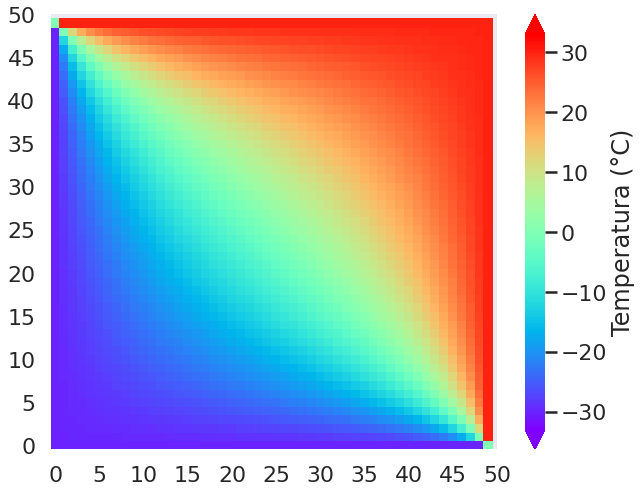

In [9]:
# numero maximo de pontos na malha
i_max, j_max = 50, 50
T = np.zeros((i_max,j_max)) 

# aplica as condições de contorno
# temperatura das paredes é fixa
T[0,:]       =-30;
T[i_max-1,:] = 30;
T[:,j_max-1] = 30;
T[:,0]       =-30;
# temperatura nas 4 quinas é a media das paredes
T[i_max-1,j_max-1] = 0.5*(T[i_max-2,j_max-1] + T[i_max-1,j_max-2]);
T[0,0]             = 0.5*(T[1,0] + T[0,1]);
T[0,j_max-1]       = 0.5*(T[1,j_max-1] + T[0,j_max-2]);
T[i_max-1,0]       = 0.5*(T[i_max-2,0] + T[i_max-1,1]);

# inicia o cronometro
start_time = time.time()

# resolve as equações de laplace pras condições de contono
x_max, y_max = 50, 50
T = laplace_matriz(T.T, x_max, y_max, w = 1.8)

# faz o plot
plt.figure(figsize = (10, 8)) #inicia a figura com um tamanho especifico

T_max = np.max(T)
T_min = np.min(T)
label = "Temperatura (°C)"
draw(T, x_max, y_max, label, T_min, T_max)

# para o cronometro
print("Execution time: {:.5f}".format(time.time() - start_time))

In [10]:
# criar o GIF
import os
import imageio

if plotar:
    pasta = folder
    imageio.plugins.freeimage.download()

    graph_list = os.listdir("/content/{}".format(pasta)) # lista de arquivos dentro da pasta
    graph_list = sorted(graph_list) # coloca os arquivos em ordem alfabetica

    images = []
    
    for image_file in graph_list: # pra cada arquivo dentro da pasta,
        if "checkpoints" not in image_file:
            image = imageio.imread("/content/{}/".format(pasta) + image_file) # ler o arquivo e armazenar em uma variavel
            images.append(image) # adicionar a image à lista de imagens

    imageio.mimsave("/content/{}.gif".format(pasta), images, "GIF-FI", fps = 10) # fazer um GIF com a lista de imagens

# Equação de Poisson para f(x,y)

$
\frac{\partial^{2}}{\partial x^{2}} \phi{\left(x,y \right)} + \frac{\partial^{2}}{\partial y^{2}} \phi{\left(x,y \right)} = f{\left(x,y \right)}
$

In [11]:
# escreve a equação em LATEX
import sympy

x = sympy.symbols("x")
y = sympy.symbols("y")

phi = sympy.Function("phi")
tf = sympy.Function("tf")

eq = sympy.Equality(sympy.diff(phi(x,y),x,x) + sympy.diff(phi(x,y),y,y),tf(x,y))
print(sympy.latex(eq))
print("")
eq

\frac{\partial^{2}}{\partial x^{2}} \phi{\left(x,y \right)} + \frac{\partial^{2}}{\partial y^{2}} \phi{\left(x,y \right)} = \operatorname{tf}{\left(x,y \right)}



Eq(Derivative(phi(x, y), (x, 2)) + Derivative(phi(x, y), (y, 2)), tf(x, y))

In [12]:
# metodo SOR
# se quiser fazer o plot a cada iteração (demora muito mais)
plotar = False
folder = "fig2"
!mkdir ./$folder

def poisson_sor(phi, tf, x_max, y_max, w = 1, erromax = 10 ** -3):
    i_max, j_max = tf.shape
    x_step = x_max / (i_max - 1)
    y_step = y_max / (j_max - 1)
    erro = 100 

    dxdx = 1 / x_step ** 2
    dydy = 1 / y_step ** 2

    beta = dydy / dxdx 

    for itera in range(100000):
        phi_old = phi.copy()

        # iterar primeiro pelas colunas
        for j in range(1,j_max-1):
            for i in range(1,i_max-1):      
                phi[i,j] = phi_old[i,j] * (1 - w) \
                        + w * (phi[i + 1, j] + phi[i - 1, j] + beta * (phi[i, j + 1] + phi[i, j - 1]) \
                        - tf[i,j] * (x_step) ** 2) / (2 * beta + 2)

        erro = np.max(np.abs(phi - phi_old)) / np.max(phi_old) 

        if plotar:
            plt.figure(figsize = (10,8))

            draw(phi, x_max, y_max, label = "Z")
            plt.title("Iter: {}    Variação: {:.5f}".format(str(itera).zfill(3), erro))
            plt.tight_layout()
            plt.savefig("./{}/{}".format(folder, str(itera).zfill(3)))
            plt.close()

        if erro < erromax:
            break

    print(itera)
    return phi

In [13]:
def tf(x,y):
    return -2 * np.sin(x)*np.cos(y)

def sol(x,y):
    return np.sin(x)*np.cos(y)

118
Execution time: 3.80478


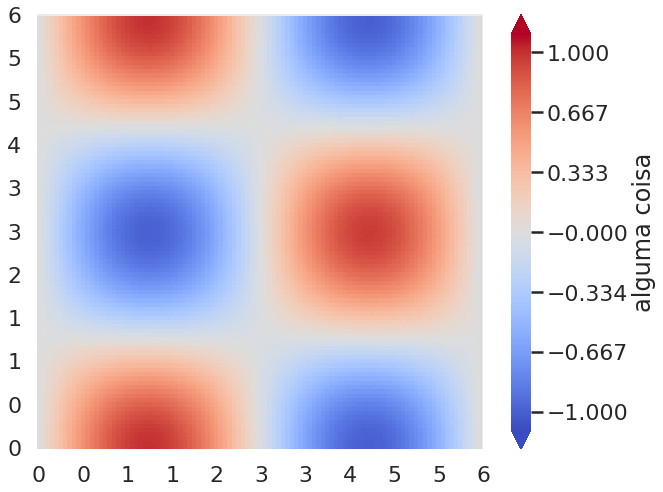

In [14]:
i_max, j_max = 100, 100 # numero maximo de pontos na malha
x_max, y_max = 2 * np.pi, 2 * np.pi # dominio da função f

x_step = x_max / (i_max - 1)
y_step = y_max / (j_max - 1)

f = np.array([tf(i,j) for i in np.linspace(0, x_max, i_max) for j in np.linspace(0, y_max, j_max)])
f = np.reshape(f, (i_max, j_max))

phi = np.zeros((i_max, j_max))
for i in range(i_max):
    for j in range(j_max):
        if ( i > 0 and i < i_max -1 and j > 0 and j < j_max - 1):
            phi[i,j] = 0
        else:
            phi[i,j] = sol(i * x_step, j * y_step)

# inicia o cronometro
start_time = time.time()

# resolve as equações de laplace pras condições de contono
phi = poisson_sor(phi, f, x_max, y_max, w = 1.8)

# faz o plot
plt.figure(figsize = (10,8)) #inicia a figura com um tamanho especifico

phi_max = np.max(phi)
phi_min = np.min(phi)
label = "alguma coisa"
draw(phi, x_max, y_max, label, phi_min, phi_max, "coolwarm")

# para o cronometro
print("Execution time: {:.5f}".format(time.time() - start_time))

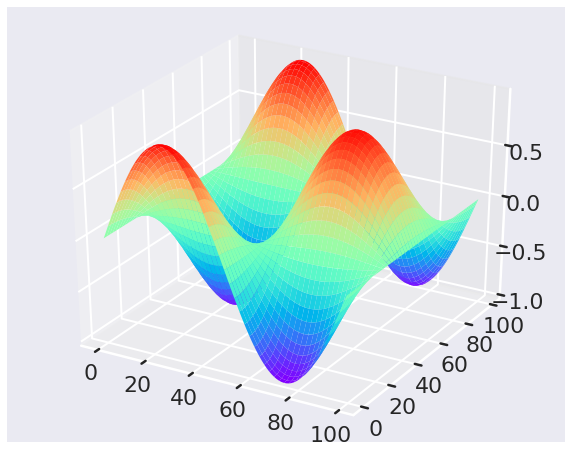

In [15]:
X, Y = np.meshgrid([i for i in range(i_max)], [j for j in range(j_max)])
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches((10,8)) #inicia a figura com um tamanho especifico
_ = ax.plot_surface(X,Y,phi.T, cmap = "rainbow", edgecolor='none')

In [16]:
X, Y = np.meshgrid([i for i in range(i_max)], [j for j in range(j_max)])
fig = go.Figure(data=[go.Surface(x = X, y = Y, z = phi.T, colorscale = "rainbow")])
fig.update_layout(width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [17]:
# metodo de matriz

def poisson_matriz(phi, tf, x_max, y_max, w = 1, erromax = 10 ** -3):
    i_max, j_max = phi.shape
    x_step = x_max / (i_max - 1)
    y_step = y_max / (j_max - 1)
    beta = (x_step / y_step) ** 2;
    
    A = np.zeros((i_max*j_max, i_max*j_max));
    b = np.zeros((i_max*j_max, 1));
    
    for i in range(i_max):
        for j in range(j_max):
            ind = i + j * i_max;

            # pontos a serem resolvidos
            if ( i > 0 and i < (i_max -1) and j > 0 and j < (j_max - 1)):

                # pontos em volta do ponto desejado
                indip1        = (i+1) + (j+0)*i_max;
                indim1        = (i-1) + (j+0)*i_max;
                indjp1        = (i+0) + (j+1)*i_max;
                indjm1        = (i+0) + (j-1)*i_max;
                
                # coeficientes dos pontos ao redor
                A[ind,indip1] = 1;
                A[ind,indim1] = 1;
                A[ind,indjp1] = beta;
                A[ind,indjm1] = beta;
            
                # coeficiente do ponto a ser resolvido
                A[ind,ind]      = -2 - 2 * beta;
                b[ind]        = x_step**2 * tf[i,j];

            # pontos das condições de contorno
            else:
                A[ind,ind] = 1;
                b[ind]   = phi[i,j];

    # resolve o sistema
    # phi = gauss_seidel(A, b, w, erromax) # A solução não converge corretamente

    # phi = np.linalg.solve(A,b)
    phi = scipy.sparse.linalg.spsolve(A,b)

    # reorganiza o vetor solução de volta para a matrix
    # pra entender oq ta acontecendo aqui, faz uns testes com matrizes pequenas
    phi = np.reshape(np.reshape(phi, (j_max, i_max)).T.flatten(), (i_max, j_max))

    return phi

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



Execution time: 0.54942


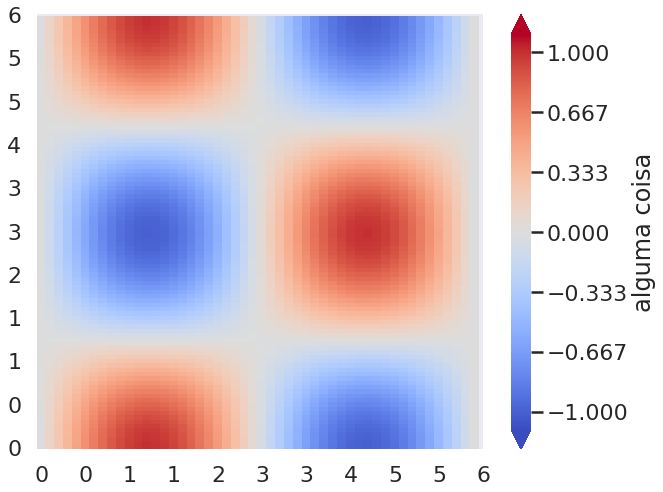

In [18]:
i_max, j_max = 50, 100 # numero maximo de pontos na malha
x_max, y_max = 2 * np.pi, 2 * np.pi # dominio da função f
x_step = x_max / (i_max - 1)
y_step = y_max / (j_max - 1)

f = np.array([tf(x,y) for x in np.linspace(0, x_max, i_max) for y in np.linspace(0, y_max, j_max)])
f = f.reshape((i_max, j_max))

phi = np.zeros((i_max, j_max))
for i in range(i_max):
    for j in range(j_max):
        if ( i > 0 and i < i_max -1 and j > 0 and j < j_max - 1):
            phi[i,j] = 0
        else:
            phi[i,j] = sol(i * x_step, j * y_step) 

# inicia o cronometro
start_time = time.time()

# resolve as equações de laplace pras condições de contono
phi = poisson_matriz(phi, f, x_max, y_max)

# faz o plot
plt.figure(figsize = (10,8)) #inicia a figura com um tamanho especifico

phi_max = np.max(phi)
phi_min = np.min(phi)
label = "alguma coisa"
draw(phi, x_max, y_max, label, phi_min, phi_max, "coolwarm")

# para o cronometro
print("Execution time: {:.5f}".format(time.time() - start_time))

In [19]:
fig.update_layout(width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

# Malha aerofolio

In [20]:
def naca(i_max, j_max, serie):
    serie = str(serie);
    m = float(serie[0]) / 100;
    p = float(serie[1]) / 10;
    t = float(serie[2:4]) / 100;
    
    dtheta = np.array([i for i in range((i_max+1)//2)]);
    xc = 0.5 * (1 + np.cos( -2 * np.pi * (dtheta) / (i_max - 1) )); 
    yt = 5 * t * (0.2969 * xc ** 0.5 - 0.1260 * xc ** 1 - 0.3516 * xc ** 2 + 0.2843 * xc ** 3 - 0.1036 * xc ** 4);  
    
    yc = np.zeros(xc.shape);
    for i in range((i_max+1)//2):
        if xc[i] < p:
            yc[i] = m * (2 * p * xc[i] - xc[i] ** 2) / p**2;
            theta = np.arctan(2*m* (p-xc[i]) /(p)**2);
        else:
            yc[i] = m * ((1 - 2 * p) + 2 * p * xc[i] - xc[i] ** 2) / (1 - p)**2;
            theta = np.arctan(2*m*(p-xc[i])/(1 - p)**2);
    
    if p > 0:
        xup   = xc - yt * np.sin(theta);
        xdown = xc + yt * np.sin(theta);
        
        yup   = yc + yt * np.cos(theta);
        ydown = yc - yt * np.cos(theta);
    else:
        xup = xc;
        yup = yt;

        xdown = xc;
        ydown = - yt;
    
    x = np.concatenate((xup, np.flip(xdown)), axis = 0);
    y = np.concatenate((yup, np.flip(ydown)), axis = 0);
    
    if x.shape[0] > i_max:
        xup = xup[:-1];
        yup = yup[:-1];
        x = np.concatenate((xup, np.flip(xdown)), axis = 0);
        y = np.concatenate((yup, np.flip(ydown)), axis = 0);

    return x, y

In [21]:
def fronteira(R, i_max, j_max):
    dtheta = np.array([i for i in range(i_max)])
    x = R * np.cos( 2 * np.pi * (dtheta) / (i_max - 1) );
    y = R * np.sin( 2 * np.pi * (dtheta) / (i_max - 1) );

    return x, y

In [22]:
def inter_pontos(x, y, i_max, j_max):
    for j in range(1, j_max - 1):
        x[:,j] = x[:,0] + (x[:,j_max - 1] - x[:,0]) * (j) / (j_max - 1);
        y[:,j] = y[:,0] + (y[:,j_max - 1] - y[:,0]) * (j) / (j_max - 1);

    return x, y

In [23]:
def draw_malha(a, b, x, y, gridcolor):
    fig.update_layout(xaxis = dict(showgrid = False, zeroline = False, range = [-1, 1]),
                  yaxis = dict(showgrid = False, zeroline = False, range = [-1, 1]),
                  width = 1300,
                  height = 800,
                  dragmode = "pan")

    fig.add_trace(go.Carpet(
        a = a,
        b = b,
        x = x,
        y = y,

        aaxis = dict(
        startlinewidth = 2,
        showticklabels = "none",
        showgrid = True,
        endlinewidth = 2,
        gridcolor = gridcolor
        ),

        baxis = dict(
        showticklabels = "none",
        showgrid = True,
        gridcolor = gridcolor
        )
    ))

In [24]:
def malha_start(R, i_max, j_max, serie = "0012"):
    x = np.zeros((i_max, j_max));
    y = np.zeros((i_max, j_max));

    x[:, 0], y[:, 0] = naca(i_max, j_max, serie);
    x[:, 0] = x[:, 0] - 0.5;
    x[:, j_max-1], y[:, j_max-1] = fronteira(R, i_max, j_max);

    x, y = inter_pontos(x, y, i_max, j_max)

    return x, y

In [25]:
i_max, j_max = 60, 30

x, y = malha_start(3, i_max, j_max, serie = "0012")

a = x[0,0:j_max]
b = np.linspace(0, 2 * np.pi, i_max)

fig = go.Figure()
draw_malha(a, b, x, y, gridcolor = "white")
fig.show()

In [26]:
# se quiser fazer o plot a cada iteração (demora muito mais)
plotar = False
folder = "fig3" # nome da pasta onde as figuras são salvas
!mkdir ./$folder

def malha_laplace_sor(x, y, i_max, j_max, w = 1, erromax = 10 ** -3):
    de = 2 * np.pi / (i_max - 1)
    dr = ((x[:,j_max - 2] - x[:,1]) ** 2 + (y[:,j_max - 2] - y[:,1]) ** 2) ** 0.5 / (j_max - 1)

    for itera in range(10000):
        x_temp = x.copy()
        y_temp = y.copy()

        for i in range(i_max):
            dn = dr[i]
            for j in range(1, j_max -1):
                # dado que o dominio de i é circular, os valores de i = 0 e i = i_max - 1 são iguais
                if ( i == 0 or i == i_max - 1):
                    dxdn = (x[i  , j + 1] - x[i        ,j - 1]) / (2 * dn);
                    dydn = (y[i  , j + 1] - y[i        ,j - 1]) / (2 * dn); 
                    dxde = (x[1  , j    ] - x[i_max - 2,j    ]) / (2 * de);
                    dyde = (y[1  , j    ] - y[i_max - 2,j    ]) / (2 * de);

                    a = (dxdn) ** 2 + (dydn) ** 2;
                    b = (dxde) * (dxdn) + (dyde) * (dydn);
                    c = (dxde) ** 2 + (dyde) ** 2;

                    x_temp[i,j] =     x[i,j] * (1 - w) \
                                +    (a * (x[1  ,j  ] + x[i_max-2,j  ]) / de ** 2\
                                - 2 * b * (x[1  ,j+1] - x[1,j-1] - x[i_max-2,j+1] + x[i_max-2,j-1]) / (4 * de * dn) \
                                +     c * (x[i  ,j+1] + x[i  ,j-1]) / dn ** 2) / (2 * a / de ** 2 + 2 * c / dn ** 2) * w;
                            
                    y_temp[i,j] =     y[i,j] * (1 - w) \
                                +    (a * (y[1  ,j  ] + y[i_max-2,j  ]) / de ** 2\
                                - 2 * b * (y[1  ,j+1] - y[1,j-1] - y[i_max-2,j+1] + y[i_max-2,j-1]) / (4 * de * dn) \
                                +     c * (y[i  ,j+1] + y[i  ,j-1]) / dn ** 2)    / (2 * a / de ** 2 + 2 * c / dn ** 2) * w;
                else:
                    dxdn = (x[i  , j + 1] - x[i    ,j - 1]) / (2 * dn);
                    dydn = (y[i  , j + 1] - y[i    ,j - 1]) / (2 * dn);
                    dxde = (x[i+1, j    ] - x[i - 1,j    ]) / (2 * de);
                    dyde = (y[i+1, j    ] - y[i - 1,j    ]) / (2 * de);

                    a = (dxdn) ** 2 + (dydn) ** 2;
                    b = (dxde) * (dxdn) + (dyde) * (dydn);
                    c = (dxde) ** 2 + (dyde) ** 2;

                    x_temp[i,j] =     x[i,j] * (1 - w) \
                                +    (a * (x[i+1,j  ] + x[i-1,j  ]) / de ** 2\
                                - 2 * b * (x[i+1,j+1] - x[i+1,j-1] - x[i-1,j+1] + x[i-1,j-1]) / (4 * de * dn) \
                                +     c * (x[i  ,j+1] + x[i  ,j-1]) / dn ** 2) / (2 * a / de ** 2 + 2 * c / dn ** 2) * w;
                            
                    y_temp[i,j] =     y[i,j] * (1 - w) \
                                +    (a * (y[i+1,j  ] + y[i-1,j  ]) / de ** 2\
                                - 2 * b * (y[i+1,j+1] - y[i+1,j-1] - y[i-1,j+1] + y[i-1,j-1]) / (4 * de * dn) \
                                +     c * (y[i  ,j+1] + y[i  ,j-1]) / dn ** 2) / (2 * a / de ** 2 + 2 * c / dn ** 2) * w;
                    

        erro = np.sum(np.abs(x_temp - x)) + np.sum(np.abs(y_temp - y))
        x = x_temp.copy()
        y = y_temp.copy()

        if itera % 10 == 0:
            print("Iteração: {} Erro: {}".format(itera, erro))
            clear_output(wait=True)

            if plotar:
                plt.figure(figsize = (8,8))
                plt.axis("off")
                plt.plot(x,y, linewidth = 0.8)
                plt.plot(x.T,y.T, "--", color = "gray", linewidth = 0.4)
                plt.title("Iter: {}, Variação: {:.4f}".format(str(itera).zfill(4), erro))
                plt.tight_layout()
                plt.savefig("./{}/{}.png".format(folder, str(itera).zfill(4)))
                plt.close()

        if erro < erromax:
            print(itera)
            break

    return x, y    

In [27]:
# inicia o cronometro
start_time = time.time()

i_max, j_max = 60, 30

fig = go.Figure()
x, y = malha_start(2, i_max, j_max, serie = "2412")
draw_malha(a, b, x, y, gridcolor = "white")

a = x[0,0:j_max]
b = np.linspace(0, 2 * np.pi, i_max)

x, y = malha_laplace_sor(x, y, i_max, j_max, w = 1)

draw_malha(a, b, x, y, gridcolor = "gray")
fig.show()

# para o cronometro
print("Execution time: {:.5f}".format(time.time() - start_time))

1867


Execution time: 65.27488


In [43]:
def malha_laplace_matriz(x, y, i_max, j_max, w = 1, erromax = 10 ** -3):
    de = 1
    dn = 1
    xA = np.zeros((i_max*j_max, i_max*j_max));
    yA = np.zeros((i_max*j_max, i_max*j_max));
    xb = np.zeros((i_max*j_max, 1));
    yb = np.zeros((i_max*j_max, 1));

    for itera in range(7):
        for i in range(i_max):
            for j in range(j_max):
                ind = i + j * i_max;
                
                # pontos na condição de contorno
                if ( j == 0 or j == j_max - 1):
                    xA[ind,ind] = 1
                    yA[ind,ind] = 1
                    xb[ind] = x[i,j]
                    yb[ind] = y[i,j]

                # pontos a serem resolvidos
                else:
                    # dado que o dominio de i é circular, os valores em i = 0 e i = i_max - 1 são iguais
                    if ( i == 0 or i == i_max - 1):
                        dxdn = (x[i  , j + 1] - x[i        ,j - 1]) / (2 * dn);
                        dydn = (y[i  , j + 1] - y[i        ,j - 1]) / (2 * dn); 
                        dxde = (x[1  , j    ] - x[i_max - 2,j    ]) / (2 * de);
                        dyde = (y[1  , j    ] - y[i_max - 2,j    ]) / (2 * de);

                        # pontos ao redor
                        indip1        = (1)       + (j+0)*i_max;
                        indim1        = (i_max-2) + (j+0)*i_max;
                        indjp1        = (i+0)     + (j+1)*i_max;
                        indjm1        = (i+0)     + (j-1)*i_max;
                        # pontos nas diagonais do ponto
                        indip1jm1        = (1)       + (j-1)*i_max;
                        indim1jp1        = (i_max-2) + (j+1)*i_max;
                        indip1jp1        = (1)       + (j+1)*i_max;
                        indim1jm1        = (i_max-2) + (j-1)*i_max;

                    else:
                        dxdn = (x[i  , j + 1] - x[i    ,j - 1]) / (2 * dn);
                        dydn = (y[i  , j + 1] - y[i    ,j - 1]) / (2 * dn);
                        dxde = (x[i+1, j    ] - x[i - 1,j    ]) / (2 * de);
                        dyde = (y[i+1, j    ] - y[i - 1,j    ]) / (2 * de);

                        # pontos ao redor
                        indip1        = (i+1) + (j+0)*i_max;
                        indim1        = (i-1) + (j+0)*i_max;
                        indjp1        = (i+0) + (j+1)*i_max;
                        indjm1        = (i+0) + (j-1)*i_max;
                        # pontos na diagonal do ponto
                        indip1jm1        = (i+1) + (j-1)*i_max;
                        indim1jp1        = (i-1) + (j+1)*i_max;
                        indip1jp1        = (i+1) + (j+1)*i_max;
                        indim1jm1        = (i-1) + (j-1)*i_max;

                    a = (dxdn) ** 2 + (dydn) ** 2;
                    b = (dxde) * (dxdn) + (dyde) * (dydn);
                    c = (dxde) ** 2 + (dyde) ** 2;
                    
                    xA[ind,ind] = -(2 * a / de ** 2 + 2 * c / dn ** 2)
                    xA[ind,indip1] =  a / de ** 2 
                    xA[ind,indim1] =  a / de ** 2
                    xA[ind,indip1jp1]  = - 2 * b / (4 * de * dn)
                    xA[ind,indim1jp1]  =   2 * b / (4 * de * dn)
                    xA[ind,indip1jm1]  =   2 * b / (4 * de * dn)
                    xA[ind,indim1jm1]  = - 2 * b / (4 * de * dn)
                    xA[ind,indjp1] =  c / dn ** 2
                    xA[ind,indjm1] =  c / dn ** 2

                    yA[ind,ind] = -(2 * a / de ** 2 + 2 * c / dn ** 2)
                    yA[ind,indip1] =  a / de ** 2
                    yA[ind,indim1] =  a / de ** 2
                    yA[ind,indip1jp1]  = - 2 * b / (4 * de * dn)
                    yA[ind,indim1jp1]  =   2 * b / (4 * de * dn)
                    yA[ind,indip1jm1]  =   2 * b / (4 * de * dn)
                    yA[ind,indim1jm1]  = - 2 * b / (4 * de * dn)
                    yA[ind,indjp1] =  c / dn ** 2
                    yA[ind,indjm1] =  c / dn ** 2

        x_old = x.copy()
        x = scipy.sparse.linalg.spsolve(xA,xb)
        x = np.reshape(np.reshape(x, (j_max, i_max)).T.flatten(), (i_max, j_max))

        y_old = y.copy()
        y = scipy.sparse.linalg.spsolve(yA,yb)
        y = np.reshape(np.reshape(y, (j_max, i_max)).T.flatten(), (i_max, j_max))
    
        erro = np.sum(np.abs(x_old - x)) + np.sum(np.abs(y_old - y))

        if itera % 10 == 0:
            print("Iteração: {} Erro: {}".format(itera, erro))
            clear_output(wait=True)

        if erro < erromax:
            break

    return x, y

In [44]:
# inicia o cronometro
start_time = time.time()

i_max, j_max = 61, 31

fig = go.Figure()
x, y = malha_start(2, i_max, j_max, serie = "2412")
draw_malha(a, b, x, y, gridcolor = "white")

a = x[0,0:j_max]
b = np.linspace(0, 2 * np.pi, i_max)

x, y = malha_laplace_matriz(x, y, i_max, j_max, w = 1)

draw_malha(a, b, x, y, gridcolor = "gray")
fig.show()

# para o cronometro
print("Execution time: {:.5f}".format(time.time() - start_time))

Execution time: 1.01729
